# Reading and processing LHCb data files

LHCb data files that are ready for analysis (nTuples) are stored as **TTree** objects within ROOT files.

ROOT files are compressed binary files that in general need a ROOT installation to be read. 

There are numerous different ways to go about reading and processing these types of datasets. Today, I will cover a few of the methods I use and discuss some pros and cons for each of them.

I will be using a small Run 3 simulated sample of $B^0 \to K^{*0}\mu^+\mu^-$ decays.


## The classic way with C++

The traditional way to process datasets in the form of TTrees is using the ROOT library directly in C++.

This requires that a ROOT installation is available on your system. On most remote systems we work on, e.g. lxplus, nectar, etc., ROOT is available via CVMFS. Otherwise, you can install it locally.

For this tutorial, I have installed ROOT using conda:
```
conda create -c conda-forge --name root_conda root python=3.8
conda activate root_conda
```

Using ROOT in C++ directly is generally the fastest approach, but it can be quite challenging to learn, especially if you are unfamiliar with C++.

Typically for a C++ project, you would write all of your data processing functions in a set of header/source files and executables and compile it all together before running anything. 

But ROOT actually allows you to use C++ interactively, including within this (nominally python based) Jupyter notebook.

Note: **Working interactively is not a recommended or sustainable approach for real physics analyses, this is just for illustration purposes.**

In [1]:
import ROOT

In [2]:
%jsroot on

ROOT lets you write C++ code in a python based Jupyter notebook.

Just add the `%%cpp` magic.

The only issue with this seems to be that syntax highlighting doesn't work properly (at least not for me).

Note: you can also run a C++ kernel for the notebook and then mix in python code using the `%%python` magic

Below is an example of how to read and display the contents of a dataset using ROOT:

In [3]:
%%cpp
// Open the file
TFile* inFile = TFile::Open("B02KstMuMu_w40_42_magup.root");

// Extract the TTree object
TTree* tree = (TTree*)inFile->Get("DecayTree");

// Uncomment below to display the contents of the tree
// tree->Print();

You can even access the variables, functions, etc. that you define in the C++ cells using python.

For example, the TTree we defined as `tree` above can be accesssed in python as `ROOT.tree`.

In [4]:
tree = ROOT.tree
print(type(tree))
print(tree.GetEntries(), "entries in the tree.")

<class cppyy.gbl.TTree at 0x558b90bc67c0>
128208 entries in the tree.


In the above, we open the ROOT file, then extract the TTree object from the file.

We can also very easily make plots of any branch in the tree.

In [5]:
%%cpp
TCanvas c("c", "c", 400, 300);
TH1D hBM("hBM", ";#it{m(B)} [GeV/#it{c}^{2}];Events", 100, 4800, 7100);
tree->Draw("B_M>>hBM");
hBM.Draw();
c.Draw();

In [6]:
%%cpp
TCanvas c1("c1", "c1", 400, 300);
tree->Draw("B_BPVIPCHI2");
c1.Draw();

#### Simple data processing with an event loop

We can use the dedicated methods of the TTree class to access the values of event variables in each branch of the tree, allowing us to do whatever computations we may want with them event-by-event.

For example, calculating the squared dimuon mass, $q^2 \equiv m^2(\mu\mu)$ using the four-momentum components of the $\mu^+$ and the $\mu^-$.

In [14]:
%%cpp
// Define variables to store components of mu_plus and mu_minus momentum
float mup_px = 0., mup_py = 0., mup_pz = 0., mup_e = 0.;
float mum_px = 0., mum_py = 0., mum_pz = 0., mum_e = 0.;

cout<<"Initially, the variables are all zero, as I defined them: "<<endl;
cout<<"    mup_px = "<<mup_px<<", mup_py = "<<mup_py<<", mup_pz = "<<mup_pz<<", mup_e = "<<mup_e<<endl;
cout<<"    mum_px = "<<mum_px<<", mum_py = "<<mum_py<<", mum_pz = "<<mum_pz<<", mum_e = "<<mum_e<<endl;

// Tell the TTree to link these variables to the corresponding branches in the tree by providing the addresses.
tree->SetBranchAddress("L1_PX", &mup_px);
tree->SetBranchAddress("L1_PY", &mup_py);
tree->SetBranchAddress("L1_PZ", &mup_pz);
tree->SetBranchAddress("L1_PE", &mup_e);

tree->SetBranchAddress("L2_PX", &mum_px);
tree->SetBranchAddress("L2_PY", &mum_py);
tree->SetBranchAddress("L2_PZ", &mum_pz);
tree->SetBranchAddress("L2_PE", &mum_e);


// For best performance, we can configure the tree to read in only the branches want 
// This can make a big difference to the processing speed if there are many branches, as we have here (over 1800 branches reduced to just 8)
// First switch everything off
tree->SetBranchStatus("*", 0);

// Turn on the branches we want, one by one
tree->SetBranchStatus("L1_PX", 1);
tree->SetBranchStatus("L1_PY", 1);
tree->SetBranchStatus("L1_PZ", 1);
tree->SetBranchStatus("L1_PE", 1);

tree->SetBranchStatus("L2_PX", 1);
tree->SetBranchStatus("L2_PY", 1);
tree->SetBranchStatus("L2_PZ", 1);
tree->SetBranchStatus("L2_PE", 1);


// Calling tree->GetEntry() fills the associated variables with the values from the tree
tree->GetEntry(0);
cout<<endl;
cout<<"Called tree->GetEntry()"<<endl;
cout<<endl;

cout<<"Now the variables hold the values from the first event in the dataset: "<<endl;
cout<<"    mup_px = "<<mup_px<<", mup_py = "<<mup_py<<", mup_pz = "<<mup_pz<<", mup_e = "<<mup_e<<endl;
cout<<"    mum_px = "<<mum_px<<", mum_py = "<<mum_py<<", mum_pz = "<<mum_pz<<", mum_e = "<<mum_e<<endl;


Initially, the variables are all zero, as I defined them: 
    mup_px = 0, mup_py = 0, mup_pz = 0, mup_e = 0
    mum_px = 0, mum_py = 0, mum_pz = 0, mum_e = 0

Called tree->GetEntry()

Now the variables hold the values from the first event in the dataset: 
    mup_px = 812.78, mup_py = -2753.35, mup_pz = 48990.1, mup_e = 49074.2
    mum_px = -1723.26, mum_py = -880.76, mum_pz = 35633.5, mum_e = 35686.2


Now we will loop over the events in the tree and calculate the $q^2$ value for each event, and store the resulting values in a new tree.

When we start the event loop, each time we call `tree->GetEntry()`, the variables we defined will be filled with the values we want from the next event in the tree.

In the same way, we can link a new branch to the resulting $q^2$ variable and have the branch be filled each time we call `tree->Fill()`. In this case the new branch will be stored in a separate tree to the original, for reasons that will be explained below.

In [15]:
%%cpp
// For timing
#include <chrono>

using std::chrono::high_resolution_clock;
using std::chrono::duration_cast;
using std::chrono::duration;
using std::chrono::milliseconds;

// Create a new TFile to store the output
// The "RECREATE" argument means we will create a new file, overwriting it if it exists already
TFile* outFile = TFile::Open("q2_tree.root", "RECREATE");

// Make a new TTree to store the q2 values
TTree* newTree = new TTree("newTree", "newTree");

// Define a variable to hold the q2 value
float q2 = 0.0;

// Create a branch in the new tree linked to the q2 variable defined above
newTree->Branch("q2", &q2, "q2/F");

// Time how long the loop takes to execute
auto t1 = high_resolution_clock::now();

// When we call newTree->Fill(), it will fill the "q2" branch with whatever is stored in the q2 variable to which it is linked.
for (int i=0; i<tree->GetEntries(); i++){
    
    tree->GetEntry(i);

    // ROOT has built in four-vector classes making kinematic calculations easy
    TLorentzVector mup_p4(mup_px, mup_py, mup_pz, mup_e);
    TLorentzVector mum_p4(mum_px, mum_py, mum_pz, mum_e);

    q2 = ((mup_p4 + mum_p4).M2()) * 1e-6;

    newTree->Fill();
}
auto t2 = high_resolution_clock::now();


duration<double, std::milli> ms_double = t2 - t1;

cout <<"Event loop took " << ms_double.count() << " ms\n";
cout<<endl;

newTree->Print();


// Write the new TTree containing the q2 values to the output file
// Note: since we opened a new TFile right before creating the new TTree, the latter is automatically owned by the former 
// meaning it will be written there by default, and will also be deleted from memory when we close the file.
newTree->Write();

outFile->Close();

Event loop took 1943 ms

******************************************************************************
*Tree    :newTree   : newTree                                                *
*Entries :   128208 : Total =          515122 bytes  File  Size =     443084 *
*        :          : Tree compression factor =   1.16                       *
******************************************************************************
*Br    0 :q2        : q2/F                                                   *
*Entries :   128208 : Total  Size=     514821 bytes  File Size  =     443084 *
*Baskets :       16 : Basket Size=      32000 bytes  Compression=   1.16     *
*............................................................................*


#### Writing trees and object ownership

The concept of object ownership in ROOT can be difficult to get ones head around.

As mentioned in the comments above, the new TTree, `newTree` we created was owned by the newly opened TFile `outFile` and was automatically being written into the file as we filled the tree. The tree writing is completed by the `Write()` function.

Ownership usually belongs to the most recently open `TFile`. Therefore, if we did not create this new file, the new TTree would have been owned by the original input file.

**This is generally not advisable, since you often don't have full write access to wherever your input file is stored. This can potentially lead to corruption of the input file.**

**For similar reasons, it is recommended to store derived branches in a separate TTree to the original one, that can be written to a different file.**

ROOT has a nice way to link trees from different files that will be covered below. 

This is also more performant in the sense that only the new branch needs to be written to a file, instead of rewriting the entire original tree (which can have many branches) along with it.

When we called `outFile->Close()`, this closed the file and `newTree` was deleted. So in order to use it again, we need to read it back in.

Note: We could have avoided this by not closing the file straight away. That was just to further illustrate the concept of ownership.

In [7]:
%%cpp
// Be sure to change the argument to "READ", otherwise we would overwrite the file with a blank one.
TFile* q2File = TFile::Open("q2_tree.root", "READ");

// Get the TTree containing the q2 values
TTree* q2Tree = (TTree*)q2File->Get("newTree");

Plot the $q^2$ distribution.

In [8]:
%%cpp
c.Clear();
TH1D hq2("hq2", ";#it{q}^{2} [GeV^{2}/#it{c}^{4}];Events", 100, 0, 20);
q2Tree->Draw("q2>>hq2");
hq2.Draw();
c.Draw();

In [9]:
%%cpp
q2File->Close();

#### Friend trees

Rarely is it ever necessary in ROOT to modify the contents of an existing TTree or the contents of an existing TFile.

Creating new derived branches is indeed a very common operation, e.g. for calculating new kinematic varriables as above, for storing event weights, MVA scores, etc.

It is tempting to think that it would be much more convenient to have all branches in the one tree. But as discussed above, there are reasons to avoid this.

The solution is to use *friend trees*.

If new branches need to be created to store derived values, e.g. the $q^2$ value as we did above, then it can be stored in a separate TTree and written to a separate TFile.

The new tree can then be listed a *freind* of the original tree, allowing its contents to be accessed as if it were part of the same tree, despite being stored in a different location. 

**One assumption to keep in mind is that the two trees need to have the same number and ordering of events.**

In [10]:
%%cpp
tree->AddFriend("newTree", "q2_tree.root");

In [11]:
%%cpp
tree->SetBranchStatus("B_M", 1);
// We can now simply reference the q2 branch as if were contained in the original tree
// Here we are making a 2D plot with one branch "B_M" from the original tree and one branch "q2" from the friend tree
tree->Draw("B_M:q2>>h(100, 0, 20, 100, 4800, 7100)","","COLZ");
c.Draw();

Another benefit of using ROOT itself, is that there are many in-built classes that expedite common physics analysis tasks.

One (slightly outdated) example is the TLorentzVector class used above that makes four-vector operations very simple.
Apparently similar functionality is actually available in newer uproot versions.
(Not to mention TLorentzVector is actually deprecated in ROOT, with more efficient successors now implmented.)

Perhaps a more consequential example is the `TEfficieny` class in ROOT.
This is a commonly used class for claculating/storing efficiencies with uncertainties handled fully internally.

Once all processing of the input file is complete, you should close the file.

Note: closing the input file will delete the `tree` object, i.e. the input tree, along with any other objects that were owned by the input file. Don't try to access anything from the input file after you have closed it or you will get a segmetiation fault and crash the program.

In [12]:
%%cpp
inFile->Close();

## Python options

Python is most common alternative to C++ for processing ROOT files.

### PyROOT

PyROOT is a python interface to ROOT. 

It allows one to use all the same ROOT functionality as in C++, but the main program can be written in Python.

For most practical purposes, this simply requires dropping the explicit typing and replacing all ROOT classnames etc. with ROOT.classname. For example, the following line creating a histogram in C++,
```
TH1D h("h", "h", 100, 0, 1000);
```
would become
```
h = ROOT.TH1D("h", "h", 100, 0, 1000)
```
Note: in python, all variables are pointers, so strictly speaking the python code is actually equivalent to
```
TH1D* h = new TH1D("h", "h", 100, 0, 1000);
```

**One of the few things that is actually a bit different in PyROOT is creating and accessing branches of a tree.**
Again due in part to the fact that python variable are pointers so some different methods for providing addresses to the TTree are needed.

Overall, it's generally a little easier in Python.

**The disadvantage, of course, is that loops in python are way slower than C++.**
So looping over many events is not recommended when using PyROOT.

In [ ]:
# Open the file
inFile = ROOT.TFile.Open("B02KstMuMu_w40_42_magup.root")

# Extract the TTree object
tree = inFile.Get("DecayTree")

# For best performance, we can configure the tree to read in only the branches want 
# This can make a big difference to the processing speed if there are many branches, as we have here (over 1800 branches reduced to just 8)
# First switch everything off
tree.SetBranchStatus("*", 0)

# # Turn on the branches we want, one by one
tree.SetBranchStatus("L1_PX", 1)
tree.SetBranchStatus("L1_PY", 1)
tree.SetBranchStatus("L1_PZ", 1)
tree.SetBranchStatus("L1_PE", 1)

tree.SetBranchStatus("L2_PX", 1)
tree.SetBranchStatus("L2_PY", 1)
tree.SetBranchStatus("L2_PZ", 1)
tree.SetBranchStatus("L2_PE", 1)


In [42]:
# See that only the activated branches are shown
tree.Show(0)

======> EVENT:0
 L1_PX           = 812.78
 L1_PY           = -2753.35
 L1_PZ           = 48990.1
 L1_PE           = 49074.2
 L2_PX           = -1723.26
 L2_PY           = -880.76
 L2_PZ           = 35633.5
 L2_PE           = 35686.2


In [26]:
from timeit import default_timer as timer

In [ ]:
from array import array

# Create a new TFile to store the output
# The "RECREATE" argument means we will create a new file, overwriting it if it exists already
outFile = ROOT.TFile.Open("q2_tree_py.root", "RECREATE")

# Make a new TTree to store the q2 values
newTree = ROOT.TTree("newTree", "newTree")

# Define a variable to hold the q2 value
# Note: must be defined as an array in python
q2 = array('f', [0])

# Create a branch in the new tree linked to the q2 variable defined above
newTree.Branch("q2", q2, "q2/F")

start = timer()

# When we call newTree->Fill(), it will fill the "q2" branch with whatever is stored in the q2 variable to which it is linked.
# Looping over events is syntactically easier in python
for event in tree:

    # Can just access the leaves of the branches
    mup_px = event.GetLeaf("L1_PX").GetValue()
    mup_py = event.GetLeaf("L1_PY").GetValue()
    mup_pz = event.GetLeaf("L1_PZ").GetValue()
    mup_e = event.GetLeaf("L1_PE").GetValue()
    mum_px = event.GetLeaf("L2_PX").GetValue()
    mum_py = event.GetLeaf("L2_PY").GetValue()
    mum_pz = event.GetLeaf("L2_PZ").GetValue()
    mum_e = event.GetLeaf("L2_PE").GetValue()

    # ROOT has built in four-vector classes making kinematic calculations easy
    mup_p4 = ROOT.TLorentzVector(mup_px, mup_py, mup_pz, mup_e)
    mum_p4 = ROOT.TLorentzVector(mum_px, mum_py, mum_pz, mum_e)

    # Insert the q2 value into the array
    q2[0] = ((mup_p4 + mum_p4).M2()) * 1e-6

    newTree.Fill()

    

end = timer()
print("Event loop took", (end - start) * 1e3, "ms")

newTree.Print()

newTree.Show(0)


# Write the new TTree containing the q2 values to the output file
# Note: since we opened a new TFile right before creating the new TTree, the latter is automatically owned by the former 
# meaning it will be written there by default, and will also be deleted from memory when we close the file.
newTree.Write()

outFile.Close()



Event loop took 188168.5472689569 ms
******************************************************************************
*Tree    :newTree   : newTree                                                *
*Entries :   128208 : Total =          515122 bytes  File  Size =     443084 *
*        :          : Tree compression factor =   1.16                       *
******************************************************************************
*Br    0 :q2        : q2/F                                                   *
*Entries :   128208 : Total  Size=     514821 bytes  File Size  =     443084 *
*Baskets :       16 : Basket Size=      32000 bytes  Compression=   1.16     *
*............................................................................*
======> EVENT:0
 q2              = 9.14077


The tree we got out in the end should be identical to what we did with C++ before. 

**However, this time in python the event loop takes 1.5 to 2 minutes for 128k events.
Comparing this to the C++ equivalent, which took only around 1.5 seconds, really demonstrates why C++ reigns supreme for processing large data files.**

### Uproot

Most of you are no doubt familiar with the `uproot` package (I won't spend much time on it).

`uproot` is a user-friendly python package for reading ROOT files that does not require an actual ROOT installation.

It can be easily installed with `pip` or `conda`.

It can be used to quickly get branches of trees, histograms, graphs, etc. in the form of Numpy arrays, or Pandas dataframes.

This is most useful if you are not very familiar with ROOT.

But even if you are, it is also very useful if you plan to use python based packages such as: 
- `XGBoost` which is very common and effective for training machine learning based multivariate analysis tools, e.g. a BDT classifier.
- `matplotlib` which arguably allows for much nicer plots than native ROOT plotting. 

In [13]:
import uproot

In [14]:
with uproot.open("B02KstMuMu_w40_42_magup.root") as iF:
    tree = iF["DecayTree"]
    B_M = tree["B_M"].array(library='np')
    

print(B_M)

[5299.24316406 5270.49462891 5208.88720703 ... 5453.44384766 5281.71972656
 5276.64501953]


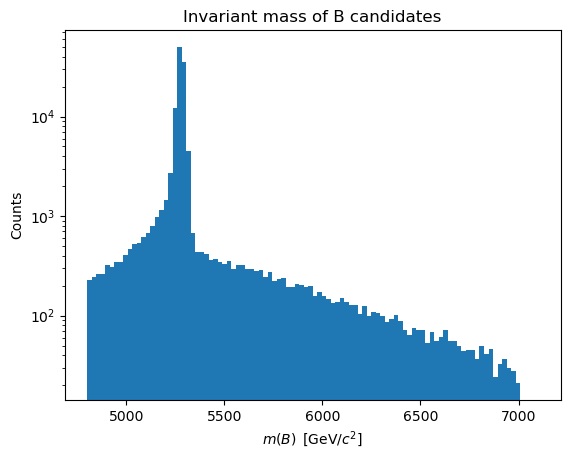

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist, bins, _ = ax.hist(B_M, bins=100, range=(4800, 7100))
ax.set_xlabel(r"$m(B)\,$ [GeV/$c^2$]")
ax.set_ylabel("Counts")
ax.set_title("Invariant mass of B candidates")
ax.set_yscale('log')
plt.show()

In some case, uproot may be faster than PyROOT, since vectorised operations on numpy arrays actually run in C/C++, avoiding the need to loop over events in python.

#### Downsides of uproot

It does not have complete ROOT compatibility, in the sense that reading/writing functionality is not implemented for all ROOT objects in uproot. It is therefore not a complete substitute.

**Uproot is generally still not recommended for large datasets or complex processing.**

Uproot has significant overhead and is usually still slow in comparison to working in C++ when processing many events. This applies even in the case of simply reading large files, let alone looping over them and running actual computations. 

When you read a branch of a TTree with uproot, you need to read the entire branch into memory. TTrees are much more optimised in terms of memory usage.

It also means you are mostly restricted to python libraries to do the data processing and analysis.

## Bridging the gap with RDataFrame
The RDataFrame class is a more modern addition to the ROOT library that aims to provide a versatile high-level interface for data processing while still achieving fast performance.

The idea is similar to data frames in other languages, for example, Pandas data frames in python or indeed those of the R programming language.

A TTree can be read straight into an RDataFrame just by providing the filename and name of the tree object. 


In [20]:
inputdir = "."
filename = "B02KstMuMu_w40_42_magup.root"
treename = "DecayTree"

In [21]:
# Create a dataframe to read in the tree
df = ROOT.RDataFrame(treename, f"{inputdir}/{filename}")

In [22]:
# Print the first 10 rows for a few columns in the dataset
df.Display(["B_M", "B_BKGCAT", "B_BPVCHI2DOF", "B_Hlt1TrackMVADecision_TOS", "H1_PROBNN_K"], 10).Print()

+-----+-------------+----------+--------------+----------------------------+-------------+
| Row | B_M         | B_BKGCAT | B_BPVCHI2DOF | B_Hlt1TrackMVADecision_TOS | H1_PROBNN_K | 
+-----+-------------+----------+--------------+----------------------------+-------------+
| 0   | 5299.243164 | 10       | 0.438716     | true                       | 0.991599    | 
+-----+-------------+----------+--------------+----------------------------+-------------+
| 1   | 5270.494629 | 10       | 0.515282     | true                       | 0.999793    | 
+-----+-------------+----------+--------------+----------------------------+-------------+
| 2   | 5208.887207 | 70       | 0.523975     | false                      | 0.833494    | 
+-----+-------------+----------+--------------+----------------------------+-------------+
| 3   | 5278.687500 | 10       | 0.525951     | false                      | 1.000000    | 
+-----+-------------+----------+--------------+----------------------------+---------

#### Apply selections

Arbitrary selections can be imposed using any columns in the dataset via the `Filter()` method.

Here, the requirements are defined as strings. 
This might seem a little annoying, but **the benefit is that strings are internally just-in-time (JIT) compiled into C++ code which makes the data processing much faster than if we ran it using python.**

In [23]:
# Define selection requirements
cutHlt1     = "(B_Hlt1TrackMVADecision_TOS || B_Hlt1TwoTrackMVADecision_TOS || B_Hlt1TrackMuonMVADecision_TOS)"
cutBMass    = "(B_M > 5239.58 && B_M < 5319.58)"
cutKstMass  = "(Kst_M > 796 && Kst_M < 996)"

In [24]:
# (optional) Activate some internal logging information to see performance statistics
verbosity = ROOT.Experimental.RLogScopedVerbosity(ROOT.Detail.RDF.RDFLogChannel(), ROOT.Experimental.ELogLevel.kInfo)

In [25]:
# Count number of events before any filtering
nEvents = df.Count().GetValue()
print(nEvents, "events in the initial dataset.")

# Apply selection using the Filter() method
# Note: result is saved to a new variable here which effectively creates a new dataframe
dfFilt = df.Filter(f"{cutHlt1}&&{cutBMass}&&{cutKstMass}")

# Count number of events after filtering
nFiltered = dfFilt.Count().GetValue()
print(nFiltered, "events in the dataset after apply selection requirements.")
print(f"    ==> efficiency = {nFiltered/nEvents*100:.3f} %")

128208 events in the initial dataset.
82379 events in the dataset after apply selection requirements.
    ==> efficiency = 64.254 %


Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event loop number 1.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:853 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Nothing to jit and execute.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:931 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Finished event loop number 1 (0.01s CPU, 0.00715804s elapsed).
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event 

#### Define new columns

Defining new columns is very simple. 

For example, everything we did in C++ to calculate $q^2$ for each event can be easily performed in 2 lines of code:


In [26]:
dilepton        = "TLorentzVector(L1_PX+L2_PX, L1_PY+L2_PY, L1_PZ+L2_PZ, L1_PE+L2_PE)"

In [27]:
df = df.Define("dilepton", dilepton).Define("q2", "dilepton.M2()*1e-6")

Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:867 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Just-in-time compilation phase completed in 0.814922 seconds.


It's a little less trivial to time things here since RDataFrame implements lazy execution, meaning it builds up a computation graph as you define new columns, filter events, etc. and only executes the computations when it is necessary. This also allows you to create forks in the computation graph and have the RDataFrame internally track everything so that execution is not duplicated unnecessarily.

RDataFrame internally logs information such as the time taken to JIT compile things and execute event loops. I haven't quite figured out how to meaningfully interpret the numbers yet, but in principle it is good information to have.

You can alternatively define several columns and make various selections in a single line by chaining them together:

In [28]:
# Create a fresh dataframe to read in the tree
df2 = ROOT.RDataFrame(treename, f"{inputdir}/{filename}")

# Do several operations in a single line
df2 = df2.Define("dilepton", dilepton).Define("q2", "dilepton.M2()*1e-6").Filter(f"{cutHlt1}&&{cutBMass}&&{cutKstMass}")

Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:867 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Just-in-time compilation phase completed in 0.287720 seconds.


Here is how you can visualise the internal computation graph:

In [29]:
# Prints the graph to a dot file
ROOT.RDF.SaveGraph(df2, "./df_graph.dot")

# # Prints the graph to standard output
# ROOT.RDF.SaveGraph(df)

! dot -Tpng df_graph.dot -o df_graph.png

Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:853 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Nothing to jit and execute.


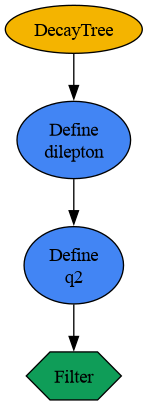

In [30]:
# insert computation graph image
from IPython.display import Image
Image(filename='df_graph.png')

In [31]:
# Define the four-momenta of the hadrons
Kp_p4           = "TLorentzVector(H1_PX, H1_PY, H1_PZ, H1_PE)"
pim_p4          = "TLorentzVector(H2_PX, H2_PY, H2_PZ, H2_PE)"

dihadron        = "TLorentzVector(H1_PX+H2_PX, H1_PY+H2_PY, H1_PZ+H2_PZ, H1_PE+H2_PE)"
B0_p4           = "TLorentzVector(B_PX, B_PY, B_PZ, B_ENERGY)"

df = df.Define("Kp_p4", Kp_p4)
df = df.Define("pim_p4", pim_p4)
df = df.Define("B0_p4", B0_p4)

The expression we actually provide to the Define function can be arbitrarily complex and can return a vast range of output types, as we shall see.

For example, one can define actual C++ functions to be JIT compiled that can be used as expressions to define new columns or filter a dataset.

Below are two examples that simply return the correct four-momentum for the $\mu^+$ and $\mu^-$ based on the PDGID (charge and particle type) of the leptons.

In [32]:
# Define functions to return muon four momenta
ROOT.gInterpreter.Declare("""
TLorentzVector get_mup_p4(int l1_ID, int l2_ID, double l1_PX, double l1_PY, double l1_PZ, double l1_PE,
                       double l2_PX, double l2_PY, double l2_PZ, double l2_PE) {
    TLorentzVector mup;
    if (l1_ID == 13 && l2_ID == -13) {
        mup = TLorentzVector(l1_PX, l1_PY, l1_PZ, l1_PE);
    } else if (l1_ID == -13 && l2_ID == 13) {
        mup = TLorentzVector(l2_PX, l2_PY, l2_PZ, l2_PE);
    } else {
        cout<<"l1_ID "<<l1_ID<<endl;
        cout<<"l2_ID  "<<l2_ID<<endl;
    }
    return mup;
}
""")
ROOT.gInterpreter.Declare("""
TLorentzVector get_mum_p4(int l1_ID, int l2_ID, double l1_PX, double l1_PY, double l1_PZ, double l1_PE,
                       double l2_PX, double l2_PY, double l2_PZ, double l2_PE) {
    TLorentzVector mum;
    if (l1_ID == 13 && l2_ID == -13) {
        mum = TLorentzVector(l2_PX, l2_PY, l2_PZ, l2_PE);
    } else if (l1_ID == -13 && l2_ID == 13) {
        mum = TLorentzVector(l1_PX, l1_PY, l1_PZ, l1_PE);
    } else {
        cout<<"l1_ID "<<l1_ID<<endl;
        cout<<"l2_ID  "<<l2_ID<<endl;
    }
    return mum;
}
""")

True

These functions, once declared, can be called in the Define() expression to create new columns in the dataframe.

In [33]:
df = df.Define("mup_p4", "get_mup_p4(L1_ID, L2_ID, L1_PX, L1_PY, L1_PZ, L1_PE, L2_PX, L2_PY, L2_PZ, L2_PE)")
df = df.Define("mum_p4", "get_mum_p4(L1_ID, L2_ID, L1_PX, L1_PY, L1_PZ, L1_PE, L2_PX, L2_PY, L2_PZ, L2_PE)")

In [34]:
# The function can be accessed in python as ROOT.function_name
print(ROOT.get_mum_p4)

ROOT.get_mum_p4(13,-13,1,1,1,5,1,1,1,5).Print()

<C++ overload "get_mum_p4" at 0x7f0caf15db80>
(x,y,z,t)=(1.000000,1.000000,1.000000,5.000000) (P,eta,phi,E)=(1.732051,0.658479,0.785398,5.000000)


#### Importing precompiled C++ libraries

In fact, it is possible to import an entire precompiled C++ library to perform aribitry data processing tasks.

This avoids the need to JIT compile and also avoids having to write C++ code in the form of a string -.-

Below, I import a custom C++ library containing functions that calculate the $B^0 \to K^{*0}\mu^+\mu^-$ decay angles, $\cos \theta_\ell$, $\cos \theta_K$, and $\phi$ using the four momenta of all the particles in the decay chain.

This library could have been compiled using something like cmake and/or a Makefile or directly with your favourite C++ compiler.

In this case, we can use ROOTs own compiler and even do it from here in the notebook.

In [89]:
# Need to be in the directory with the C++ files to be compiled
%cd tools
# run the compiler
ROOT.gROOT.ProcessLine(".L Angles.cc+")
# change back to parent directory
%cd ..

/home/shared/tutorial/LHCbAnalysisBasics/tools
/home/shared/tutorial/LHCbAnalysisBasics


Info in <TUnixSystem::ACLiC>: creating shared library /home/shared/tutorial/LHCbAnalysisBasics/tools/./Angles_cc.so


In [35]:
# Load the C++ library for decay angles
# The library is compiled from the C++ code in the tools directory
# The shared library can be compiled in a standalone way using ROOT
# To create shared library, first start root in tools directory and type 
# ".L Angles.cc++"
libdir = "./tools"

ROOT.gInterpreter.AddIncludePath(libdir)
ROOT.gInterpreter.ProcessLine('#include "Angles.h"')    # Header with the declaration of the library functions
ROOT.gSystem.Load(f"{libdir}/Angles_cc.so")             # Library with the functions to calculate decay angles

0

In [36]:
# These functions are defined in their own namespace called kstmm
print(ROOT.kstmm.calculateDecayAngles)

<C++ overload "calculateDecayAngles" at 0x7f0ca60fbe80>


Just as before we can use the C++ functions to now define new columns in the dataframe.

In [37]:
# -------------------------------------------------
# Calculate decay angles
# -------------------------------------------------
# The angles are calculated using the four-momenta of the B0, muons, and hadrons
# The actual calculation is done in the C++ library tools/Angles.cc
# The angles are returned as a C++ std::tuple of three values: (cosThetaL, cosThetaK, phi)
df = df.Define("angles", "kstmm::calculateDecayAngles(B0_p4, mup_p4, mum_p4, Kp_p4, pim_p4, B_ID)")
# df.Display(["angles"]).Print()

# Get the individual angles from the tuple
df = df.Define("cosThetaL", "std::get<0>(angles)")
df = df.Define("cosThetaK", "std::get<1>(angles)")
df = df.Define("phi", "std::get<2>(angles)")

In [38]:
hctl = df.Histo1D(("hctl", ";cos #it{#theta}_{#it{l}};Counts", 100, -1, 1), "cosThetaL")
hctk = df.Histo1D(("hctl", ";cos #it{#theta}_{#it{K}};Counts", 100, -1, 1), "cosThetaK")
hphi = df.Histo1D(("hphi", ";#it{#phi};Counts", 100, -3.14, 3.14), "phi")

cctl = ROOT.TCanvas("cctl", "cctl", 400, 300)
hctl.Draw()
cctl.Draw()


Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event loop number 3.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:867 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Just-in-time compilation phase completed in 2.090205 seconds.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:931 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Finished event loop number 3 (0.65s CPU, 0.651414s elapsed).


In [39]:
cctk = ROOT.TCanvas("cctk", "cctk", 400, 300)
hctk.Draw()
cctk.Draw()

In [40]:
cphi = ROOT.TCanvas("cphi", "cphi", 400, 300)
hphi.Draw()
cphi.Draw()

#### Saving new branches with Snapshots

The RDataFrame `Snapshot()` method allows specific columns of the dataframe to be saved directly to a ROOT file in TTree format.

These trees can then be used added as friend trees when creating the dataframe next time to avoid recomputing things.

In [41]:
# Save the angles to a new TTree
df.Snapshot("DecayTree", "angles_tree.root", ["cosThetaL", "cosThetaK", "phi"])

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x558b9fe3f040>

Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event loop number 4.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:867 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Just-in-time compilation phase completed in 1.900425 seconds.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:931 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Finished event loop number 4 (0.82s CPU, 0.815272s elapsed).


#### Friend trees with RDataFrame

RDataFrame can easily handle friend trees.

All that is required is to setup a tree with friends *first*, then create the RDataFrame from it.

In [42]:
# Open the main file
inFile = ROOT.TFile.Open("B02KstMuMu_w40_42_magup.root")

# Extract the main TTree object
tree = inFile.Get("DecayTree")

# Add the q2 tree as a friend to the main tree
tree.AddFriend("newTree", "q2_tree_py.root")

# Create a dataframe to directly read the tree including its friends
df_friend = ROOT.RDataFrame(tree)

Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:853 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Nothing to jit and execute.


In [43]:
# The datframe contains the B_M and q2 branches, which are from the main tree and the friend tree, respectively
df_friend.Display(["B_M", "q2"], 10).Print()

+-----+-------------+-----------+
| Row | B_M         | q2        | 
+-----+-------------+-----------+
| 0   | 5299.243164 | 9.140768  | 
+-----+-------------+-----------+
| 1   | 5270.494629 | 12.046855 | 
+-----+-------------+-----------+
| 2   | 5208.887207 | 15.363330 | 
+-----+-------------+-----------+
| 3   | 5278.687500 | 0.236994  | 
+-----+-------------+-----------+
| 4   | 5285.071289 | 13.762801 | 
+-----+-------------+-----------+
| 5   | 5160.005859 | 3.440733  | 
+-----+-------------+-----------+
| 6   | 5288.348145 | 3.440733  | 
+-----+-------------+-----------+
| 7   | 5257.195801 | 9.293385  | 
+-----+-------------+-----------+
| 8   | 5260.979492 | 14.631278 | 
+-----+-------------+-----------+
| 9   | 5283.066895 | 14.809097 | 
+-----+-------------+-----------+


Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event loop number 0.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:867 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Just-in-time compilation phase completed in 0.286488 seconds.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:931 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Finished event loop number 0 (0.01s CPU, 0.00589204s elapsed).


#### Converting from RDataFrame to numpy

RDataFrame has built in methods for extracting columns into numpy arrays.
The output is a dictionary with the keys corresponding to column names from the data frame and the values being numpy arrays corresponding to the rows.

In [44]:
colList = ["B_M", "q2", "cosThetaL", "cosThetaK", "phi"]
np_df = df.AsNumpy(colList)
print(np_df)

{'B_M': ndarray([5299.24316406, 5270.49462891, 5208.88720703, ..., 5453.44384766,
         5281.71972656, 5276.64501953]), 'q2': ndarray([ 9.1407672 , 12.04758033, 15.36488595, ..., 13.31848574,
          3.12169111,  9.998114  ]), 'cosThetaL': ndarray([-0.58960084, -0.91436654, -0.59585357, ..., -0.99908944,
         -0.03634533,  0.11154538]), 'cosThetaK': ndarray([ 0.16040565, -0.40786084,  0.68752272, ..., -0.31964939,
         -0.89576481, -0.75768869]), 'phi': ndarray([-0.88792774,  2.19772562,  2.00955665, ..., -1.55627087,
         -0.29027498, -0.69841788])}


Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:894 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Starting event loop number 5.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:853 in void ROOT::Detail::RDF::RLoopManager::Jit()>: Nothing to jit and execute.
Info in <[ROOT.RDF] Info /home/conda/feedstock_root/build_artifacts/bld/rattler-build_root_base_1740585294/work/root-source/tree/dataframe/src/RLoopManager.cxx:931 in void ROOT::Detail::RDF::RLoopManager::Run(bool)>: Finished event loop number 5 (0.8s CPU, 0.795093s elapsed).


#### Converting to a Pandas dataframe

The `AsNumpy()` format is particularly well suited for quickly converting from an RDataFrame to a Pandas dataframe, which can be a useful data format for interfacing with libraries such as XGBoost for training multivariate analysis tools as well as for other basic data processing and visualisation tasks.

In [45]:
import pandas as pd

pd_df = pd.DataFrame(np_df)
print(pd_df)

                B_M         q2  cosThetaL  cosThetaK       phi
0       5299.243164   9.140767  -0.589601   0.160406 -0.887928
1       5270.494629  12.047580  -0.914367  -0.407861  2.197726
2       5208.887207  15.364886  -0.595854   0.687523  2.009557
3       5278.687500   0.237046   0.566820   0.699477 -2.535142
4       5285.071289  13.763329  -0.180680   0.949084  0.437597
...             ...        ...        ...        ...       ...
128203  5280.011230  14.045481  -0.667104   0.351620  1.011648
128204  5275.769531  16.680103  -0.138786  -0.383946 -2.600670
128205  5453.443848  13.318486  -0.999089  -0.319649 -1.556271
128206  5281.719727   3.121691  -0.036345  -0.895765 -0.290275
128207  5276.645020   9.998114   0.111545  -0.757689 -0.698418

[128208 rows x 5 columns]


In [46]:
# Example of computing the correlation matrix between columns with pandas
corr = pd_df.corr(numeric_only=False)
print(corr)

                B_M        q2  cosThetaL  cosThetaK       phi
B_M        1.000000  0.115042   0.025235   0.007305 -0.001362
q2         0.115042  1.000000  -0.222999   0.025984  0.000066
cosThetaL  0.025235 -0.222999   1.000000  -0.044405 -0.005484
cosThetaK  0.007305  0.025984  -0.044405   1.000000 -0.009327
phi       -0.001362  0.000066  -0.005484  -0.009327  1.000000


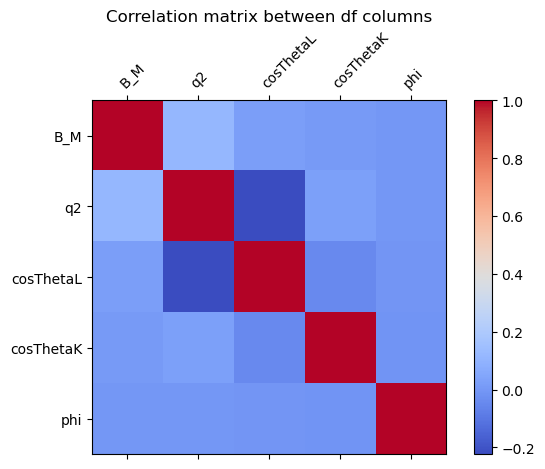

In [47]:
fig, ax = plt.subplots(tight_layout=True)
cax = ax.matshow(corr, cmap='coolwarm')
cb = fig.colorbar(cax, ax=ax)
ax.set_title(f"Correlation matrix between df columns")
ax.set_xticks(range(len(colList)), labels=colList, rotation=45, ha='left', rotation_mode='anchor')
ax.set_yticks(range(len(colList)), labels=colList)
ax.tick_params(axis='x', labelrotation=45, labelright=True)
plt.show()